In [ ]:
import pandas as pd
import numpy as np

from matplotlib import pyplot as plt
import seaborn as sns

from sklearn.linear_model import LinearRegression
from sklearn.metrics import classification_report
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split

from google.colab import drive
drive.mount('/content/drive')
drive_dir = '/content/drive/My Drive/Project_3/'

Mounted at /content/drive


In [ ]:
df = pd.read_csv(drive_dir + 'data/promotion_train_data.csv')

\(2\) How much does education matter in promotions?
- What percentage of Bachelor’s Master’s, other get promoted?
- Does education matter more for older \(>40\) or younger \(<40\)
- Masters vs. bachelor’s vs other looking at average training scores and rating
- Look at what education level is most prevalent in each department
- Split up everything by gender as well

Data engineering

Logistic Regression

#Cleaning Data

In [ ]:
df.head()

,employee_id,department,region,education,gender,recruitment_channel,no_of_trainings,age,previous_year_rating,length_of_service,KPIs_met >80%,awards_won?,avg_training_score,is_promoted
0,65438,Sales & Marketing,region_7,Master's & above,f,sourcing,1,35,5.0,8,1,0,49,0
1,65141,Operations,region_22,Bachelor's,m,other,1,30,5.0,4,0,0,60,0
2,7513,Sales & Marketing,region_19,Bachelor's,m,sourcing,1,34,3.0,7,0,0,50,0
3,2542,Sales & Marketing,region_23,Bachelor's,m,other,2,39,1.0,10,0,0,50,0
4,48945,Technology,region_26,Bachelor's,m,other,1,45,3.0,2,0,0,73,0


In [ ]:
df = df.drop('employee_id',axis = 1)

In [ ]:
for col in df.columns:
  percent = 100 * df[col].isna().sum() / df.shape[0]
  percent = round(percent,2)
  print(f'{col}: {df[col].isna().sum()} ({percent}%) missing values')

department: 0 (0.0%) missing values
region: 0 (0.0%) missing values
education: 2409 (4.4%) missing values
gender: 0 (0.0%) missing values
recruitment_channel: 0 (0.0%) missing values
no_of_trainings: 0 (0.0%) missing values
age: 0 (0.0%) missing values
previous_year_rating: 4124 (7.52%) missing values
length_of_service: 0 (0.0%) missing values
KPIs_met >80%: 0 (0.0%) missing values
awards_won?: 0 (0.0%) missing values
avg_training_score: 0 (0.0%) missing values
is_promoted: 0 (0.0%) missing values


In [ ]:
df['education'].unique()

array(["Master's & above", "Bachelor's", nan, 'Below Secondary'],
      dtype=object)

In [ ]:
#Replacing NaN instead of dropping b/c I want to keep those rows
df['education'] = df.education.fillna('Unknown')

In [ ]:
df['previous_year_rating'].unique()

array([ 5.,  3.,  1.,  4., nan,  2.])

In [ ]:
#Ratings are 1-5, so mean will mean employee was not here last year
df['previous_year_rating'] = df.previous_year_rating.fillna(df['previous_year_rating'].mean())

In [ ]:
df.dtypes

department               object
region                   object
education                object
gender                   object
recruitment_channel      object
no_of_trainings           int64
age                       int64
previous_year_rating    float64
length_of_service         int64
KPIs_met >80%             int64
awards_won?               int64
avg_training_score        int64
is_promoted               int64
dtype: object

In [ ]:
df['previous_year_rating'].unique()

array([5.        , 3.        , 1.        , 4.        , 3.32925578,
       2.        ])

In [ ]:
df['starting_age'] = df['age']-df['length_of_service']
df['total_training_score'] = df['no_of_trainings']*df['avg_training_score']
df = df.rename(columns={'KPIs_met >80%': 'KPIs_met>80%'})
df.head()

,department,region,education,gender,recruitment_channel,no_of_trainings,age,previous_year_rating,length_of_service,KPIs_met>80%,awards_won?,avg_training_score,is_promoted,starting_age,total_training_score
0,Sales & Marketing,region_7,Master's & above,f,sourcing,1,35,5.0,8,1,0,49,0,27,49
1,Operations,region_22,Bachelor's,m,other,1,30,5.0,4,0,0,60,0,26,60
2,Sales & Marketing,region_19,Bachelor's,m,sourcing,1,34,3.0,7,0,0,50,0,27,50
3,Sales & Marketing,region_23,Bachelor's,m,other,2,39,1.0,10,0,0,50,0,29,100
4,Technology,region_26,Bachelor's,m,other,1,45,3.0,2,0,0,73,0,43,73


In [ ]:
df['previous_year_rating_norm'] = (df['previous_year_rating']-df['previous_year_rating'].min())/(df['previous_year_rating'].max()-df['previous_year_rating'].min())
df.head()

,department,region,education,gender,recruitment_channel,no_of_trainings,age,previous_year_rating,length_of_service,KPIs_met>80%,awards_won?,avg_training_score,is_promoted,starting_age,total_training_score,previous_year_rating_norm
0,Sales & Marketing,region_7,Master's & above,f,sourcing,1,35,5.0,8,1,0,49,0,27,49,1.0
1,Operations,region_22,Bachelor's,m,other,1,30,5.0,4,0,0,60,0,26,60,1.0
2,Sales & Marketing,region_19,Bachelor's,m,sourcing,1,34,3.0,7,0,0,50,0,27,50,0.5
3,Sales & Marketing,region_23,Bachelor's,m,other,2,39,1.0,10,0,0,50,0,29,100,0.0
4,Technology,region_26,Bachelor's,m,other,1,45,3.0,2,0,0,73,0,43,73,0.5


#Cleaning Data 2

In [ ]:
df.head()

,department,region,education,gender,recruitment_channel,no_of_trainings,age,previous_year_rating,length_of_service,KPIs_met>80%,awards_won?,avg_training_score,is_promoted,starting_age,total_training_score,previous_year_rating_norm
0,Sales & Marketing,region_7,Master's & above,f,sourcing,1,35,5.0,8,1,0,49,0,27,49,1.0
1,Operations,region_22,Bachelor's,m,other,1,30,5.0,4,0,0,60,0,26,60,1.0
2,Sales & Marketing,region_19,Bachelor's,m,sourcing,1,34,3.0,7,0,0,50,0,27,50,0.5
3,Sales & Marketing,region_23,Bachelor's,m,other,2,39,1.0,10,0,0,50,0,29,100,0.0
4,Technology,region_26,Bachelor's,m,other,1,45,3.0,2,0,0,73,0,43,73,0.5


In [ ]:
#based off of percentages of promotion. Lowered older than 40 with 0 rating bc only 11 people
def age_rating(row):
  if row['age'] <= 40 and row['previous_year_rating'] == 0:
    return 10
  elif row['age'] <= 40 and row['previous_year_rating'] == 1:
    return 2
  elif row['age'] <= 40 and row['previous_year_rating'] == 2:
    return 4
  elif row['age'] <= 40 and row['previous_year_rating'] == 3:
    return 7
  elif row['age'] <= 40 and row['previous_year_rating'] == 4:
    return 9
  elif row['age'] <= 40 and row['previous_year_rating'] == 5:
    return 12
  elif row['age'] > 40 and row['previous_year_rating'] == 0:
    return 6
  elif row['age'] > 40 and row['previous_year_rating'] == 1:
    return 1
  elif row['age'] > 40 and row['previous_year_rating'] == 2:
    return 3
  elif row['age'] > 40 and row['previous_year_rating'] == 3:
    return 5
  elif row['age'] > 40 and row['previous_year_rating'] == 4:
    return 8
  else:
    return 11


In [ ]:
def age_KPI(row):
  if row['age'] <= 45 and row['KPIs_met>80%'] == 0:
    return 2
  elif row['age'] <= 45 and row['KPIs_met>80%'] == 1:
    return 4
  elif row['age'] > 45 and row['KPIs_met>80%'] == 0:
    return 3
  else:
    return 1

In [ ]:
df_encoded = df.copy()

In [ ]:
df_encoded['age_rating'] = df_encoded.apply(age_rating, axis=1)

In [ ]:
df_encoded['age_KPI'] = df_encoded.apply(age_KPI, axis=1)

In [ ]:
df_encoded.head()

,department,region,education,gender,recruitment_channel,no_of_trainings,age,previous_year_rating,length_of_service,KPIs_met>80%,awards_won?,avg_training_score,is_promoted,starting_age,total_training_score,previous_year_rating_norm,age_rating,age_KPI
0,Sales & Marketing,region_7,Master's & above,f,sourcing,1,35,5.0,8,1,0,49,0,27,49,1.0,12,4
1,Operations,region_22,Bachelor's,m,other,1,30,5.0,4,0,0,60,0,26,60,1.0,12,2
2,Sales & Marketing,region_19,Bachelor's,m,sourcing,1,34,3.0,7,0,0,50,0,27,50,0.5,7,2
3,Sales & Marketing,region_23,Bachelor's,m,other,2,39,1.0,10,0,0,50,0,29,100,0.0,2,2
4,Technology,region_26,Bachelor's,m,other,1,45,3.0,2,0,0,73,0,43,73,0.5,5,2


In [ ]:
#Percent of people to get promoted in each category
def promo_by_group(col):
  for i,group in df.groupby(col):
    total = group.shape[0]
    promoted = group[group['is_promoted'] == 1].shape[0]
    percent = 100*promoted/total
    print(f"{i}: promoted {percent:.2f}% of the time. ({promoted} out of {total})")

In [ ]:
category = feat_cols

for col in category:
  print(col.upper(), ':')
  print(promo_by_group(col))
  print("="*100)

DEPARTMENT :
Analytics: promoted 9.57% of the time. (512 out of 5352)
Finance: promoted 8.12% of the time. (206 out of 2536)
HR: promoted 5.62% of the time. (136 out of 2418)
Legal: promoted 5.10% of the time. (53 out of 1039)
Operations: promoted 9.01% of the time. (1023 out of 11348)
Procurement: promoted 9.64% of the time. (688 out of 7138)
R&D: promoted 6.91% of the time. (69 out of 999)
Sales & Marketing: promoted 7.20% of the time. (1213 out of 16840)
Technology: promoted 10.76% of the time. (768 out of 7138)
None
REGION :
region_1: promoted 9.51% of the time. (58 out of 610)
region_10: promoted 7.87% of the time. (51 out of 648)
region_11: promoted 5.63% of the time. (74 out of 1315)
region_12: promoted 6.60% of the time. (33 out of 500)
region_13: promoted 8.69% of the time. (230 out of 2648)
region_14: promoted 7.50% of the time. (62 out of 827)
region_15: promoted 7.91% of the time. (222 out of 2808)
region_16: promoted 6.96% of the time. (102 out of 1465)
region_17: promoted

KeyError: ignored

Copying everything over from Stephanie's notebook

In [ ]:
from sklearn.preprocessing import LabelEncoder

In [ ]:
for c in df_encoded.columns:
  if c != 'default':  
    if df_encoded[c].dtype == object:  #If it is a string, then encode it. 
        try:  
            le = LabelEncoder()           
            le.fit(df_encoded[c].unique())    
            df_encoded[c] = le.transform(df_encoded[c])  
        except Exception as e:         
            print(c)         
            print(e)

In [ ]:
female_df = df_encoded[df_encoded['gender']==0]
male_df = df_encoded[df_encoded['gender']==1]

female_train_df, female_test_df = train_test_split(female_df, test_size=0.3, random_state=0, stratify=female_df['is_promoted'])
male_train_df, male_test_df = train_test_split(male_df, test_size=0.3, random_state=0, stratify=male_df['is_promoted'])

In [ ]:
feat_cols = ['department', 'region', 'education', 'gender', 'recruitment_channel', 'no_of_trainings', 'age', 
             'previous_year_rating', 'length_of_service', 'KPIs_met>80%', 'awards_won?', 'avg_training_score', 
             'starting_age', 'total_training_score', 'previous_year_rating_norm', 'age_rating', 'age_KPI']
target_col = 'is_promoted'

female_X_train = female_train_df[feat_cols]
female_y_train = female_train_df[target_col]

male_X_train = male_train_df[feat_cols]
male_y_train = male_train_df[target_col]

female_X_test = female_test_df[feat_cols]
female_y_test = female_test_df[target_col]

male_X_test = male_test_df[feat_cols]
male_y_test = male_test_df[target_col]

In [ ]:
female_train_yes_df = female_train_df[female_train_df['is_promoted'] == 1]
female_train_yes_df = female_train_yes_df.sample(10391, replace=True)

female_train_no_df = female_train_df[female_train_df['is_promoted'] == 0]

# And now stick both DataFrames together to make a new oversampled training set
female_train_over_df = pd.concat([female_train_no_df, female_train_yes_df])

In [ ]:
male_train_yes_df = male_train_df[male_train_df['is_promoted'] == 1]
male_train_yes_df = male_train_yes_df.sample(24706, replace=True)

male_train_no_df = male_train_df[male_train_df['is_promoted'] == 0]

# And now stick both DataFrames together to make a new oversampled training set
male_train_over_df = pd.concat([male_train_no_df, male_train_yes_df])

In [ ]:
feat_cols = ['department', 'region', 'education', 'gender', 'recruitment_channel', 'no_of_trainings', 'age', 
             'previous_year_rating', 'length_of_service', 'KPIs_met>80%', 'awards_won?', 'avg_training_score', 
             'starting_age', 'total_training_score', 'previous_year_rating_norm', 'age_rating', 'age_KPI']
target_col = 'is_promoted'

female_X_train_over = female_train_over_df[feat_cols]
female_y_train_over = female_train_over_df[target_col]

In [ ]:
# Get only the customers who did not get promoted
female_train_no_df = female_train_df[female_train_df['is_promoted'] == 0]
# Then select of them to match the "1" is_promoted employees
female_train_no_df = female_train_no_df.sample(1027)

# Also grab the promoted employees
female_train_yes_df = female_train_df[female_train_df['is_promoted'] == 1]

# And now stick both DataFrames together to make a new undersampled training set
female_train_under_df = pd.concat([female_train_no_df, female_train_yes_df])

In [ ]:
# Get only the customers who did not get promoted
male_train_no_df = male_train_df[male_train_df['is_promoted'] == 0]
# Then select of them to match the "1" is_promoted employees
male_train_no_df = male_train_no_df.sample(2241)

# Also grab the promoted employees
male_train_yes_df = male_train_df[male_train_df['is_promoted'] == 1]

# And now stick both DataFrames together to make a new undersampled training set
male_train_under_df = pd.concat([male_train_no_df, male_train_yes_df])

#Looking for general facts

In [ ]:
#Rating 0 means they were not there last year
#What do these 8% of people do to get promoted?
for i in df['previous_year_rating'].unique():
  rating_df = df[df['previous_year_rating'] == i]
  total = rating_df.shape[0]
  promoted = rating_df[rating_df['is_promoted'] == 1].shape[0]
  percent = 100*promoted/total
  print(f"Employee's with previous year rating {i} were promoted {percent: .2f}% of the time. ({promoted} out of {total})")

Employee's with previous year rating 5.0 were promoted  16.36% of the time. (1921 out of 11741)
Employee's with previous year rating 3.0 were promoted  7.28% of the time. (1355 out of 18618)
Employee's with previous year rating 1.0 were promoted  1.41% of the time. (88 out of 6223)
Employee's with previous year rating 4.0 were promoted  7.94% of the time. (784 out of 9877)
Employee's with previous year rating 3.329255780917055 were promoted  8.22% of the time. (339 out of 4124)
Employee's with previous year rating 2.0 were promoted  4.28% of the time. (181 out of 4225)


In [ ]:
zero_df = df[df['previous_year_rating'] == 0]

In [ ]:
#Looks like average training score is an important factor for promotions
#0 is not promoted
#1 is promoted
for i, group in zero_df.groupby('is_promoted'):
  training_score_mean = group['avg_training_score'].mean()
  print(f"The average training score for {i} with a 0 previous year rating was {training_score_mean}")

for i, group in df.groupby('is_promoted'):
  training_score_mean = group['avg_training_score'].mean()
  print(f"The average training score for all people for {i} rating was {training_score_mean}")


The average training score for all people for 0 rating was 62.64768647786199
The average training score for all people for 1 rating was 71.32519280205655


In [ ]:
#This seems hand picked
for department,group in df.groupby('department'):
  total = group.shape[0]
  promoted = group[group['is_promoted'] == 1].shape[0]
  percent = 100*promoted/total
  print(f"Employees in the {department} department were promoted {percent:.2f}% of the time. ({promoted} out of {total})")

Employees in the Analytics department were promoted 9.57% of the time. (512 out of 5352)
Employees in the Finance department were promoted 8.12% of the time. (206 out of 2536)
Employees in the HR department were promoted 5.62% of the time. (136 out of 2418)
Employees in the Legal department were promoted 5.10% of the time. (53 out of 1039)
Employees in the Operations department were promoted 9.01% of the time. (1023 out of 11348)
Employees in the Procurement department were promoted 9.64% of the time. (688 out of 7138)
Employees in the R&D department were promoted 6.91% of the time. (69 out of 999)
Employees in the Sales & Marketing department were promoted 7.20% of the time. (1213 out of 16840)
Employees in the Technology department were promoted 10.76% of the time. (768 out of 7138)


In [ ]:
#These are not as similar which is good
#Seems like females are being promoted more than males
for department,group in df.groupby('department'):
  male_df = group[group['gender'] == 'm']
  female_df = group[group['gender'] == 'f']
  total_male = male_df.shape[0]
  total_female = female_df.shape[0]
  promoted_male = male_df[male_df['is_promoted'] == 1].shape[0]
  promoted_female = female_df[female_df['is_promoted'] == 1].shape[0]
  percent_male = 100*promoted_male/total_male
  percent_female = 100*promoted_female/total_female
  print(f"Males in the {department} department were promoted {percent_male:.2f}% of the time. ({promoted_male} out of {total_male})")
  print(f"Females in the {department} department were promoted {percent_female:.2f}% of the time. ({promoted_female} out of {total_female})")
  print('='*100)

Males in the Analytics department were promoted 9.30% of the time. (450 out of 4839)
Females in the Analytics department were promoted 12.09% of the time. (62 out of 513)
Males in the Finance department were promoted 8.14% of the time. (151 out of 1855)
Females in the Finance department were promoted 8.08% of the time. (55 out of 681)
Males in the HR department were promoted 5.52% of the time. (78 out of 1412)
Females in the HR department were promoted 5.77% of the time. (58 out of 1006)
Males in the Legal department were promoted 5.28% of the time. (47 out of 890)
Females in the Legal department were promoted 4.03% of the time. (6 out of 149)
Males in the Operations department were promoted 8.71% of the time. (581 out of 6671)
Females in the Operations department were promoted 9.45% of the time. (442 out of 4677)
Males in the Procurement department were promoted 7.87% of the time. (303 out of 3851)
Females in the Procurement department were promoted 11.71% of the time. (385 out of 328

In [ ]:
for education,group in df.groupby('education'):
  total = group.shape[0]
  promoted = group[group['is_promoted'] == 1].shape[0]
  percent = 100*promoted/total
  print(f"Employees in the {education} education level were promoted {percent:.2f}% of the time. ({promoted} out of {total})")

Employees in the Bachelor's education level were promoted 8.20% of the time. (3008 out of 36669)
Employees in the Below Secondary education level were promoted 8.32% of the time. (67 out of 805)
Employees in the Master's & above education level were promoted 9.86% of the time. (1471 out of 14925)
Employees in the Unknown education level were promoted 5.06% of the time. (122 out of 2409)


Education and Age

In [ ]:
for education,group in df.groupby('education'):
  total = group.shape[0]
  age = group[group['age'] < 40].shape[0]
  percent = 100*age/total
  print(f"Employees with {education} education level and were younger than 40 made up {percent:.2f}% of the ages. ({age} out of {total})")

Employees with Bachelor's education level and were younger than 40 made up 83.48% of the ages. (30611 out of 36669)
Employees with Below Secondary education level and were younger than 40 made up 100.00% of the ages. (805 out of 805)
Employees with Master's & above education level and were younger than 40 made up 60.03% of the ages. (8960 out of 14925)
Employees with Unknown education level and were younger than 40 made up 87.46% of the ages. (2107 out of 2409)


In [ ]:
for education,group in df.groupby('education'):
  total = group.shape[0]
  age = group[group['age'] >= 40].shape[0]
  percent = 100*age/total
  print(f"Employees with {education} education level and were older then or equal to 40 made up {percent:.2f}% of the ages. ({age} out of {total})")
print(f'The total number of employees aged 40 or older was {df[df["age"] >= 40].shape[0]}')

Employees with Bachelor's education level and were older then or equal to 40 made up 16.52% of the ages. (6058 out of 36669)
Employees with Below Secondary education level and were older then or equal to 40 made up 0.00% of the ages. (0 out of 805)
Employees with Master's & above education level and were older then or equal to 40 made up 39.97% of the ages. (5965 out of 14925)
Employees with Unknown education level and were older then or equal to 40 made up 12.54% of the ages. (302 out of 2409)
The total number of employees aged 40 or older was 12325


And with regards to promotion

In [ ]:
group_df = df.groupby(['education','is_promoted'])['age']
for education, group in group_df:
  total = group.shape[0]
  age = group[df['age'] < 40]
  age_shape = age.shape[0]
  #promoted_shape = promoted.shape[0]
  age_percent = 100*age_shape/total
  #prom_percent = 100*promoted_shape/total
  print(age_shape)
  print(f"Employees with {education} education and were younger than 40 made up {age_percent:.2f}% of the {education} education level. ({age_shape} out of {total})")
print(f'The total number of employees aged younger than 40 was {df[df["age"] < 40].shape[0]}')

27954
Employees with ("Bachelor's", 0) education and were younger than 40 made up 83.05% of the ("Bachelor's", 0) education level. (27954 out of 33661)
2657
Employees with ("Bachelor's", 1) education and were younger than 40 made up 88.33% of the ("Bachelor's", 1) education level. (2657 out of 3008)
738
Employees with ('Below Secondary', 0) education and were younger than 40 made up 100.00% of the ('Below Secondary', 0) education level. (738 out of 738)
67
Employees with ('Below Secondary', 1) education and were younger than 40 made up 100.00% of the ('Below Secondary', 1) education level. (67 out of 67)
8016
Employees with ("Master's & above", 0) education and were younger than 40 made up 59.58% of the ("Master's & above", 0) education level. (8016 out of 13454)
944
Employees with ("Master's & above", 1) education and were younger than 40 made up 64.17% of the ("Master's & above", 1) education level. (944 out of 1471)
1993
Employees with ('Unknown', 0) education and were younger than 

In [ ]:
df.groupby(['education','is_promoted'])['age'].value_counts()

education   is_promoted  age
Bachelor's  0            30     2909
                         29     2816
                         28     2585
                         31     2536
                         32     2346
                                ... 
Unknown     1            38        1
                         45        1
                         49        1
                         50        1
                         60        1
Name: age, Length: 237, dtype: int64

Ratings, Scores, and Promotion

In [ ]:
for score,group in df.groupby('total_training_score'):
  total = group.shape[0]
  promoted = group[group['is_promoted'] == 1].shape[0]
  percent = 100*promoted/total
  if percent > 0:
    print(f"Employees with a total score of {score}  were promoted {percent:.2f}% of the time. ({promoted} out of {total})")

Employees with a total score of 41  were promoted 6.25% of the time. (1 out of 16)
Employees with a total score of 42  were promoted 2.17% of the time. (1 out of 46)
Employees with a total score of 43  were promoted 4.17% of the time. (6 out of 144)
Employees with a total score of 44  were promoted 3.21% of the time. (9 out of 280)
Employees with a total score of 45  were promoted 5.31% of the time. (29 out of 546)
Employees with a total score of 46  were promoted 3.38% of the time. (31 out of 916)
Employees with a total score of 47  were promoted 4.82% of the time. (68 out of 1412)
Employees with a total score of 48  were promoted 4.56% of the time. (91 out of 1995)
Employees with a total score of 49  were promoted 4.18% of the time. (92 out of 2203)
Employees with a total score of 50  were promoted 4.45% of the time. (98 out of 2204)
Employees with a total score of 51  were promoted 4.58% of the time. (89 out of 1942)
Employees with a total score of 52  were promoted 4.29% of the tim

In [ ]:
for rating,group in df.groupby('previous_year_rating'):
  total = group.shape[0]
  promoted = group[group['is_promoted'] == 1].shape[0]
  percent = 100*promoted/total
  if percent > 0:
    print(f"Employees with a total score of {rating}  were promoted {percent:.2f}% of the time. ({promoted} out of {total})")

Employees with a total score of 1.0  were promoted 1.41% of the time. (88 out of 6223)
Employees with a total score of 2.0  were promoted 4.28% of the time. (181 out of 4225)
Employees with a total score of 3.0  were promoted 7.28% of the time. (1355 out of 18618)
Employees with a total score of 3.329255780917055  were promoted 8.22% of the time. (339 out of 4124)
Employees with a total score of 4.0  were promoted 7.94% of the time. (784 out of 9877)
Employees with a total score of 5.0  were promoted 16.36% of the time. (1921 out of 11741)


Education and Departments

In [ ]:
for education,group in df.groupby('education'):
  print(education)
  print(group['department'].value_counts())

Bachelor's
Sales & Marketing    11099
Operations            7781
Technology            4642
Procurement           4393
Analytics             3978
Finance               1895
HR                    1525
Legal                  814
R&D                    542
Name: department, dtype: int64
Below Secondary
Technology     201
Operations     176
Procurement    129
HR             128
Finance        106
Legal           65
Name: department, dtype: int64
Master's & above
Sales & Marketing    4166
Operations           3165
Procurement          2544
Technology           2196
Analytics            1037
HR                    733
Finance               499
R&D                   429
Legal                 156
Name: department, dtype: int64
Unknown
Sales & Marketing    1575
Analytics             337
Operations            226
Technology             99
Procurement            72
Finance                36
HR                     32
R&D                    28
Legal                   4
Name: department, dtype: int64

#Logistic Regression Model 1

'KPIs_met>80%', 'no_of_trainings', 'avg_training_score', 'previous_year_rating', and 'awards_won?'

In [ ]:
logr_1_clf = LogisticRegression()

In [ ]:
from sklearn.metrics import f1_score
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
from sklearn.metrics import accuracy_score

In [ ]:
from sklearn.model_selection import train_test_split

train_df, test_df = train_test_split(df, test_size=0.3)

In [ ]:
X_cols_1 = ['KPIs_met>80%','no_of_trainings','avg_training_score','previous_year_rating','awards_won?']
Y_col = 'is_promoted'

X_train = train_df[X_cols_1]
Y_train = train_df[Y_col]

X_test = test_df[X_cols_1]
Y_test = test_df[Y_col]

In [ ]:
logr_1_clf.fit(X_train, Y_train)
logr_1_clf.predict_proba(X_test)[:10]

array([[0.9271653 , 0.0728347 ],
       [0.92780461, 0.07219539],
       [0.9516162 , 0.0483838 ],
       [0.94429876, 0.05570124],
       [0.91719932, 0.08280068],
       [0.96737743, 0.03262257],
       [0.83352986, 0.16647014],
       [0.97119625, 0.02880375],
       [0.9921555 , 0.0078445 ],
       [0.88185002, 0.11814998]])

In [ ]:
preds = logr_1_clf.predict(X_test)
pd.Series(preds).value_counts()
preds

array([0, 0, 0, ..., 0, 0, 0], dtype=int64)

In [ ]:
Y_test.values

array([0, 0, 0, ..., 0, 0, 0], dtype=int64)

In [ ]:
f1 = round(f1_score(Y_test.values,preds)*100,2)
recall = round(recall_score(Y_test.values,preds)*100,2)
precision = round(precision_score(Y_test.values,preds)*100,2)
accuracy = round(accuracy_score(Y_test.values,preds)*100,2)
print(f"Accuracy: {accuracy}% \nPrecision: {precision}% \nRecall: {recall}% \nF-1: {f1}%")

Accuracy: 91.48% 
Precision: 57.69% 
Recall: 6.32% 
F-1: 11.39%


#Logistic Regression Model 1.1

'KPIs_met>80%', 'no_of_trainings', 'avg_training_score', 'previous_year_rating_norm', and 'awards_won?'

In [ ]:
logr_2_clf = LogisticRegression()

In [ ]:
from sklearn.metrics import f1_score
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
from sklearn.metrics import accuracy_score

In [ ]:
from sklearn.model_selection import train_test_split

train_df, test_df = train_test_split(df, test_size=0.3)

In [ ]:
X_cols_2 = ['KPIs_met>80%','no_of_trainings','avg_training_score','previous_year_rating_norm','awards_won?']
Y_col = 'is_promoted'

X_train = train_df[X_cols_2]
Y_train = train_df[Y_col]

X_test = test_df[X_cols_2]
Y_test = test_df[Y_col]

In [ ]:
logr_2_clf.fit(X_train, Y_train)
logr_2_clf.predict_proba(X_test)[:10]

array([[0.93473133, 0.06526867],
       [0.78260786, 0.21739214],
       [0.90221966, 0.09778034],
       [0.85220485, 0.14779515],
       [0.9759569 , 0.0240431 ],
       [0.9841254 , 0.0158746 ],
       [0.89076412, 0.10923588],
       [0.84583214, 0.15416786],
       [0.86871012, 0.13128988],
       [0.9778626 , 0.0221374 ]])

In [ ]:
preds = logr_2_clf.predict(X_test)
pd.Series(preds).value_counts()
preds

array([0, 0, 0, ..., 0, 0, 0], dtype=int64)

In [ ]:
Y_test.values

array([0, 0, 0, ..., 0, 0, 0], dtype=int64)

In [ ]:
f1 = round(f1_score(Y_test.values,preds)*100,2)
recall = round(recall_score(Y_test.values,preds)*100,2)
precision = round(precision_score(Y_test.values,preds)*100,2)
accuracy = round(accuracy_score(Y_test.values,preds)*100,2)
print(f"Accuracy: {accuracy}% \nPrecision: {precision}% \nRecall: {recall}% \nF-1: {f1}%")

Accuracy: 91.63% 
Precision: 60.29% 
Recall: 5.84% 
F-1: 10.65%


#Model 2

'KPIs_met>80%', 'no_of_trainings', 'avg_training_score', 'previous_year_rating', 'awards_won?', 'education_num', 'department_num'

In [ ]:
logr_3_clf = LogisticRegression()

In [ ]:
df['education_num'] = df['education'].replace(["Bachelor's","Master's & above","Below Secondary","Unknown"],[2,3,1,0])
df['department_num'] = df['department'].replace(['Sales & Marketing', 'Operations', 'Technology', 'Analytics',
       'R&D', 'Procurement', 'Finance', 'HR', 'Legal'],[1,2,3,4,5,6,7,8,9])

In [ ]:
from sklearn.model_selection import train_test_split

train_df, test_df = train_test_split(df, test_size=0.3)

In [ ]:
X_cols_3 = ['KPIs_met>80%','no_of_trainings','avg_training_score','previous_year_rating','awards_won?','education_num','department_num']
Y_col = 'is_promoted'

X_train = train_df[X_cols_3]
Y_train = train_df[Y_col]

X_test = test_df[X_cols_3]
Y_test = test_df[Y_col]

In [ ]:
logr_3_clf.fit(X_train, Y_train)
logr_3_clf.predict_proba(X_test)[:10]

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


array([[0.98192907, 0.01807093],
       [0.96514627, 0.03485373],
       [0.88670178, 0.11329822],
       [0.98934546, 0.01065454],
       [0.8962257 , 0.1037743 ],
       [0.97423868, 0.02576132],
       [0.95047176, 0.04952824],
       [0.84965502, 0.15034498],
       [0.91663489, 0.08336511],
       [0.9622962 , 0.0377038 ]])

In [ ]:
preds = logr_3_clf.predict(X_test)
pd.Series(preds).value_counts()
preds

array([0, 0, 0, ..., 0, 0, 0], dtype=int64)

In [ ]:
Y_test.values

array([0, 0, 0, ..., 0, 0, 0], dtype=int64)

In [ ]:
f1 = round(f1_score(Y_test.values,preds)*100,2)
recall = round(recall_score(Y_test.values,preds)*100,2)
precision = round(precision_score(Y_test.values,preds)*100,2)
accuracy = round(accuracy_score(Y_test.values,preds)*100,2)
print(f"Accuracy: {accuracy}% \nPrecision: {precision}% \nRecall: {recall}% \nF-1: {f1}%")

Accuracy: 91.85% 
Precision: 67.13% 
Recall: 6.91% 
F-1: 12.53%


#Model 2.1



'KPIs_met>80%', 'no_of_trainings', 'avg_training_score', 'previous_year_rating_norm', 'awards_won?', 'education_num', 'department_num'

In [ ]:
logr_4_clf = LogisticRegression()

In [ ]:
df['education_num'] = df['education'].replace(["Bachelor's","Master's & above","Below Secondary","Unknown"],[2,3,1,0])
df['department_num'] = df['department'].replace(['Sales & Marketing', 'Operations', 'Technology', 'Analytics',
       'R&D', 'Procurement', 'Finance', 'HR', 'Legal'],[1,2,3,4,5,6,7,8,9])

In [ ]:
from sklearn.model_selection import train_test_split

train_df, test_df = train_test_split(df, test_size=0.3)

In [ ]:
X_cols_4 = ['KPIs_met>80%','no_of_trainings','avg_training_score','previous_year_rating_norm','awards_won?','education_num','department_num']
Y_col = 'is_promoted'

X_train = train_df[X_cols_4]
Y_train = train_df[Y_col]

X_test = test_df[X_cols_4]
Y_test = test_df[Y_col]

In [ ]:
logr_4_clf.fit(X_train, Y_train)
logr_4_clf.predict_proba(X_test)[:10]

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


array([[0.84486201, 0.15513799],
       [0.95029218, 0.04970782],
       [0.9773783 , 0.0226217 ],
       [0.98368526, 0.01631474],
       [0.96461453, 0.03538547],
       [0.95296872, 0.04703128],
       [0.92007014, 0.07992986],
       [0.98605449, 0.01394551],
       [0.92704132, 0.07295868],
       [0.95840627, 0.04159373]])

In [ ]:
preds = logr_4_clf.predict(X_test)
pd.Series(preds).value_counts()
preds

array([0, 0, 0, ..., 1, 0, 0], dtype=int64)

In [ ]:
Y_test.values

array([0, 0, 0, ..., 1, 0, 0], dtype=int64)

In [ ]:
f1 = round(f1_score(Y_test.values,preds)*100,2)
recall = round(recall_score(Y_test.values,preds)*100,2)
precision = round(precision_score(Y_test.values,preds)*100,2)
accuracy = round(accuracy_score(Y_test.values,preds)*100,2)
print(f"Accuracy: {accuracy}% \nPrecision: {precision}% \nRecall: {recall}% \nF-1: {f1}%")

Accuracy: 91.6% 
Precision: 51.11% 
Recall: 8.29% 
F-1: 14.27%


#Model 3.0

Model 2.1 gives the best F1 score, so this will be 2.1 undersampled

In [ ]:
logr_5m_clf = LogisticRegression()
logr_5f_clf = LogisticRegression()

In [ ]:
df['is_promoted'].value_counts()

0    50140
1     4668
Name: is_promoted, dtype: int64

In [ ]:
print(4668/(50140+4668))

0.08517004816815063


Promotions are 8.5% of the data

In [ ]:
df_no_prom_undersamp = df[df['is_promoted'] == 0].sample(4668)
df_undersample = pd.merge(df_no_prom_undersamp,df[df['is_promoted'] == 1], how='outer')

In [ ]:
df_undersample['is_promoted'].value_counts()

1    4668
0    4668
Name: is_promoted, dtype: int64

In [ ]:
df_undersample_male = df_undersample[df_undersample['gender'] == 'm']
df_undersample_female = df_undersample[df_undersample['gender'] == 'f']

For male

In [ ]:
from sklearn.model_selection import train_test_split

train_df, test_df = train_test_split(df_undersample, test_size=0.3)

In [ ]:
X_cols_5m = ['KPIs_met>80%','no_of_trainings','avg_training_score','previous_year_rating','awards_won?','education_num','department_num']
Y_col = 'is_promoted'

X_train_5m = train_df[X_cols_5m]
Y_train = train_df[Y_col]

X_test_5m = test_df[X_cols_5m]
Y_test = test_df[Y_col]

In [ ]:
logr_5m_clf.fit(X_train_5m, Y_train)
logr_5m_clf.predict_proba(X_test_5m)[:10]

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


array([[0.2819158 , 0.7180842 ],
       [0.75582297, 0.24417703],
       [0.49705136, 0.50294864],
       [0.55679056, 0.44320944],
       [0.82328683, 0.17671317],
       [0.27200736, 0.72799264],
       [0.62651008, 0.37348992],
       [0.61532163, 0.38467837],
       [0.78335149, 0.21664851],
       [0.84628201, 0.15371799]])

In [ ]:
preds = logr_5m_clf.predict(X_test_5m)
pd.Series(preds).value_counts()
preds

array([1, 0, 1, ..., 1, 1, 0], dtype=int64)

In [ ]:
Y_test.values

array([1, 0, 0, ..., 1, 1, 0], dtype=int64)

In [ ]:
f1 = round(f1_score(Y_test.values,preds)*100,2)
recall = round(recall_score(Y_test.values,preds)*100,2)
precision = round(precision_score(Y_test.values,preds)*100,2)
accuracy = round(accuracy_score(Y_test.values,preds)*100,2)
print(f"Accuracy: {accuracy}% \nPrecision: {precision}% \nRecall: {recall}% \nF-1: {f1}%")

Accuracy: 72.08% 
Precision: 71.49% 
Recall: 73.43% 
F-1: 72.45%


              precision    recall  f1-score   support

           0       0.73      0.71      0.72      1401
           1       0.71      0.73      0.72      1400

    accuracy                           0.72      2801
   macro avg       0.72      0.72      0.72      2801
weighted avg       0.72      0.72      0.72      2801



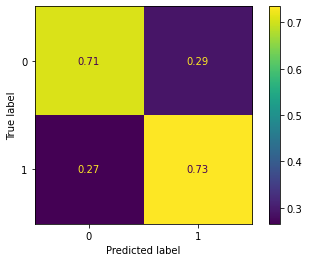

In [ ]:
from sklearn.metrics import classification_report
from sklearn.metrics import plot_confusion_matrix

preds = logr_5m_clf.predict(X_test_5m)

print(classification_report(Y_test, preds))

plot_confusion_matrix(logr_5m_clf, X_test_5m, Y_test, normalize='true');

For female

In [ ]:
from sklearn.model_selection import train_test_split

train_df, test_df = train_test_split(df_undersample, test_size=0.3)

In [ ]:
X_cols_5f = ['KPIs_met>80%','no_of_trainings','avg_training_score','previous_year_rating','awards_won?','education_num','department_num']
Y_col = 'is_promoted'

X_train_5f = train_df[X_cols_5f]
Y_train = train_df[Y_col]

X_test_5f = test_df[X_cols_5f]
Y_test = test_df[Y_col]

In [ ]:
logr_5f_clf.fit(X_train_5f, Y_train)
logr_5f_clf.predict_proba(X_test_5f)[:10]

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


array([[0.33341591, 0.66658409],
       [0.04308522, 0.95691478],
       [0.76883275, 0.23116725],
       [0.60028488, 0.39971512],
       [0.91511531, 0.08488469],
       [0.76378796, 0.23621204],
       [0.69617706, 0.30382294],
       [0.7904289 , 0.2095711 ],
       [0.21662139, 0.78337861],
       [0.87424435, 0.12575565]])

In [ ]:
preds = logr_5f_clf.predict(X_test_5f)
pd.Series(preds).value_counts()
preds

array([1, 1, 0, ..., 0, 0, 0], dtype=int64)

In [ ]:
Y_test.values

array([1, 1, 0, ..., 0, 1, 0], dtype=int64)

In [ ]:
f1 = round(f1_score(Y_test.values,preds)*100,2)
recall = round(recall_score(Y_test.values,preds)*100,2)
precision = round(precision_score(Y_test.values,preds)*100,2)
accuracy = round(accuracy_score(Y_test.values,preds)*100,2)
print(f"Accuracy: {accuracy}% \nPrecision: {precision}% \nRecall: {recall}% \nF-1: {f1}%")

Accuracy: 73.01% 
Precision: 71.88% 
Recall: 74.07% 
F-1: 72.96%


              precision    recall  f1-score   support

           0       0.74      0.72      0.73      1424
           1       0.72      0.74      0.73      1377

    accuracy                           0.73      2801
   macro avg       0.73      0.73      0.73      2801
weighted avg       0.73      0.73      0.73      2801



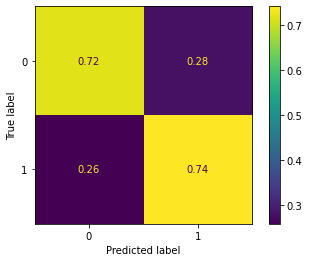

In [ ]:
from sklearn.metrics import classification_report
from sklearn.metrics import plot_confusion_matrix

preds = logr_5f_clf.predict(X_test_5f)

print(classification_report(Y_test, preds))

plot_confusion_matrix(logr_5f_clf, X_test_5f, Y_test, normalize='true');

In [ ]:
pd.DataFrame({'columns': X_cols_5f, 'importance': logr_5f_clf.coef_[0]})

,columns,importance
0,KPIs_met>80%,1.574378
1,no_of_trainings,-0.290679
2,avg_training_score,0.045523
3,previous_year_rating,0.374038
4,awards_won?,2.773412
5,education_num,0.091795
6,department_num,-0.118333


#Model with the group-identical data

## Data Loading

In [ ]:
female_X_train_over_df = pd.read_csv(drive_dir + 'data/female_X_train_over.csv')
male_X_train_over_df = pd.read_csv(drive_dir + 'data/male_X_train_over.csv')
female_y_train_over_df = pd.read_csv(drive_dir + 'data/female_y_train_over.csv')
male_y_train_over_df = pd.read_csv(drive_dir + 'data/male_y_train_over.csv')

In [ ]:
female_X_train_under_df = pd.read_csv(drive_dir + 'data/female_X_train_under.csv')
male_X_train_under_df = pd.read_csv(drive_dir + 'data/male_X_train_under.csv')
female_y_train_under_df = pd.read_csv(drive_dir + 'data/female_y_train_under.csv')
male_y_train_under_df = pd.read_csv(drive_dir + 'data/male_y_train_under.csv')

In [ ]:
female_X_train_df = pd.read_csv(drive_dir + 'data/female_X_train.csv')
male_X_train_df = pd.read_csv(drive_dir + 'data/male_X_train.csv')
female_y_train_df = pd.read_csv(drive_dir + 'data/female_y_train.csv')
male_y_train_df = pd.read_csv(drive_dir + 'data/male_y_train.csv')

In [ ]:
female_X_test_df = pd.read_csv(drive_dir + 'data/female_X_test.csv')
male_X_test_df = pd.read_csv(drive_dir + 'data/male_X_test.csv')
female_y_test_df = pd.read_csv(drive_dir + 'data/female_y_test.csv')
male_y_test_df = pd.read_csv(drive_dir + 'data/male_y_test.csv')

In [ ]:
logr_G_f_under_clf = LogisticRegression()
logr_G_m_under_clf = LogisticRegression()
logr_G_f_over_clf = LogisticRegression()
logr_G_m_over_clf = LogisticRegression()
logr_G_f_clf = LogisticRegression()
logr_G_m_clf = LogisticRegression()

In [ ]:
from sklearn.metrics import classification_report
from sklearn.metrics import plot_confusion_matrix

In [ ]:
male_X_train_over_df.head()

,Unnamed: 0,department,region,education,gender,recruitment_channel,no_of_trainings,age,previous_year_rating,length_of_service,KPIs_met>80%,awards_won?,avg_training_score,starting_age,total_training_score,previous_year_rating_norm,age_rating,age_KPI
0,11574,2,28,0,1,0,1,29,5.0,2,1,0,50,27,50,1.0,12,4
1,9454,7,22,0,1,0,1,35,1.0,5,0,0,49,30,49,0.2,2,2
2,34528,4,10,0,1,0,1,42,3.0,6,0,0,61,36,61,0.6,5,2
3,1350,4,19,2,1,0,1,46,5.0,14,0,0,58,32,58,1.0,11,3
4,14455,0,2,0,1,0,2,40,3.0,4,0,0,83,36,166,0.6,7,2


In [ ]:
X_cols_G = ['department',	'region',	'education',	'recruitment_channel',	'no_of_trainings',	'age',	'previous_year_rating', 
            'length_of_service',	'KPIs_met>80%',	'awards_won?',	'avg_training_score',	'starting_age',	'total_training_score', 
            'previous_year_rating_norm',	'age_rating',	'age_KPI']

## Female Oversample

In [ ]:
X_cols_G_f_over = ['department',	'education',	'recruitment_channel',	'no_of_trainings',	'age',	'previous_year_rating', 
                   'KPIs_met>80%',	'awards_won?',	'avg_training_score',	'starting_age',	'total_training_score', 
                   'previous_year_rating_norm',	'age_rating',	'age_KPI']
Y_col = 'is_promoted'

X_train_G_f_over = female_X_train_over_df[X_cols_G_f_over]
Y_train_G_f_over = female_y_train_over_df[Y_col]

X_test_G_f_over = female_X_test_df[X_cols_G_f_over]
Y_f_test = female_y_test_df[Y_col]

In [ ]:
logr_G_f_over_clf.fit(X_train_G_f_over, Y_train_G_f_over)

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

              precision    recall  f1-score   support

           0       0.96      0.69      0.80      4454
           1       0.19      0.74      0.30       440

    accuracy                           0.69      4894
   macro avg       0.58      0.71      0.55      4894
weighted avg       0.89      0.69      0.76      4894



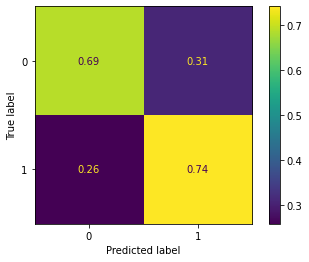

In [ ]:
preds = logr_G_f_over_clf.predict(X_test_G_f_over)

print(classification_report(Y_f_test, preds))

plot_confusion_matrix(logr_G_f_over_clf, X_test_G_f_over, Y_f_test, normalize='true');

In [ ]:
pd.DataFrame({'columns': X_cols_G_f_over, 'coefficients': logr_G_f_over_clf.coef_[0]})

,columns,coefficients
0,department,-0.068648
1,education,0.122555
2,recruitment_channel,-0.049630
3,no_of_trainings,-1.381549
4,age,-0.027817
5,previous_year_rating,0.132071
6,KPIs_met>80%,2.310673
7,awards_won?,1.284871
8,avg_training_score,0.032317
9,starting_age,-0.022006


For each run, I check the classification report, then check the coefficients and delete the coefficient of least absolute value, then run again

First Run notes:
 - From classification_report (0,1) -- Precision: (.96,.19) -- Recall: (.70,.73) -- F-1: (.81,.30)
 - Delete 'region'

Second Run notes:
 - From classification_report (0,1) -- Precision: (.96,.19) -- Recall: (.70,.74) -- F-1: (.81,.31)
 - Delete 'length_of_service'

Third Run notes:
 - From classification_report (0,1) -- Precision: (.96,.19) -- Recall: (.70,.74) -- F-1: (.81,.31)
 - Delete 'education'

Fourth Run notes:
 - From classification_report (0,1) -- Precision: (.96,.19) -- Recall: (.70,.72) -- F-1: (.81,.30)
 - Add back in 'length_of_service'

Fifth Run notes:
 - From classification_report (0,1) -- Precision: (.96,.18) -- Recall: (.69,.72) -- F-1: (.81,.29)

The models with the best scores overall are both X_cols without region, and one without length_of_service

##Male Oversample

In [ ]:
X_cols_G_m_over = ['department',	'education',	'recruitment_channel',	'no_of_trainings',	'previous_year_rating', 
                   'length_of_service',	'KPIs_met>80%',	'awards_won?',	'avg_training_score',	'starting_age',	'total_training_score', 
                   'previous_year_rating_norm',	'age_rating',	'age_KPI']
Y_col = 'is_promoted'

X_train_G_m_over = male_X_train_over_df[X_cols_G_m_over]
Y_train_G_m_over = male_y_train_over_df[Y_col]

X_test_G_m_over = male_X_test_df[X_cols_G_m_over]
Y_m_test = male_y_test_df[Y_col]

In [ ]:
logr_G_m_over_clf.fit(X_train_G_m_over, Y_train_G_m_over)

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

              precision    recall  f1-score   support

           0       0.97      0.71      0.82     10589
           1       0.19      0.74      0.30       960

    accuracy                           0.71     11549
   macro avg       0.58      0.73      0.56     11549
weighted avg       0.90      0.71      0.78     11549



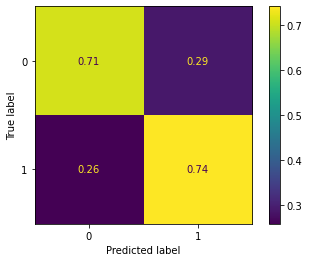

In [ ]:
preds = logr_G_m_over_clf.predict(X_test_G_m_over)

print(classification_report(Y_m_test, preds))

plot_confusion_matrix(logr_G_m_over_clf, X_test_G_m_over, Y_m_test, normalize='true');

In [ ]:
pd.DataFrame({'columns': X_cols_G_m_over, 'importance': logr_G_m_over_clf.coef_[0]})

,columns,importance
0,department,0.097309
1,education,0.046374
2,recruitment_channel,-0.023579
3,no_of_trainings,-1.508654
4,previous_year_rating,0.060414
5,length_of_service,0.003858
6,KPIs_met>80%,2.363750
7,awards_won?,1.449794
8,avg_training_score,0.018134
9,starting_age,-0.047552


For each run, I check the classification report, then check the coefficients and delete the coefficient of least absolute value, then run again

First Run notes:
 - From classification_report (0,1) -- Precision: (.97,.19) -- Recall: (.71,.74) -- F-1: (.82,.30)
 - Delete 'region'

Secind Run notes:
 - From classification_report (0,1) -- Precision: (.97,.19) -- Recall: (.71,.74) -- F-1: (.82,.30)
 - Delete 'age'

Third Run notes:
 - From classification_report (0,1) -- Precision: (.97,.19) -- Recall: (.71,.75) -- F-1: (.82,.30)
 - Delete 'length_of_service'

Fourth Run notes:
 - From classification_report (0,1) -- Precision: (.97,.19) -- Recall: (.72,.73) -- F-1: (.82,.30)
 - Add back in 'age'

Fifth Run notes:
 - From classification_report (0,1) -- Precision: (.97,.19) -- Recall: (.71,.74) -- F-1: (.82,.30)

The model with the best scores overall was X_cols without 'region' and 'age'

## Female Undersample

In [ ]:
X_cols_G_f_under = ['department',	'education',	'no_of_trainings',	'age',	'previous_year_rating', 
                    'length_of_service', 'KPIs_met>80%',	'awards_won?',	'avg_training_score',	'starting_age',	'total_training_score', 
                    'previous_year_rating_norm',	'age_rating',	'age_KPI']
Y_col = 'is_promoted'

X_train_G_f_under = female_X_train_under_df[X_cols_G_f_under]
Y_train_G_f_under = female_y_train_under_df[Y_col]

X_test_G_f_under = female_X_test_df[X_cols_G_f_under]
Y_f_test = female_y_test_df[Y_col]

In [ ]:
logr_G_f_under_clf.fit(X_train_G_f_under, Y_train_G_f_under)

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

              precision    recall  f1-score   support

           0       0.96      0.69      0.81      4454
           1       0.19      0.74      0.30       440

    accuracy                           0.70      4894
   macro avg       0.58      0.72      0.56      4894
weighted avg       0.89      0.70      0.76      4894



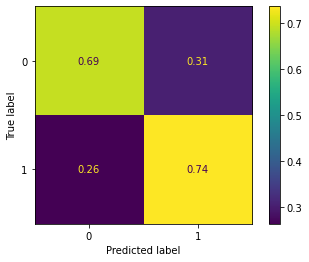

In [ ]:
preds = logr_G_f_under_clf.predict(X_test_G_f_under)

print(classification_report(Y_f_test, preds))

plot_confusion_matrix(logr_G_f_under_clf, X_test_G_f_under, Y_f_test, normalize='true');

In [ ]:
pd.DataFrame({'columns': X_cols_G_f_under, 'coefficients': logr_G_f_under_clf.coef_[0]})

,columns,coefficients
0,department,-0.062066
1,education,0.036879
2,no_of_trainings,-1.109268
3,age,-0.026764
4,previous_year_rating,0.161137
5,length_of_service,0.002274
6,KPIs_met>80%,2.052732
7,awards_won?,1.231006
8,avg_training_score,0.030775
9,starting_age,-0.029038


For each run, I check the classification report, then check the coefficients and delete the coefficient of least absolute value, then run again

First Run notes:
 - From classification_report (0,1) -- Precision: (.96,.19) -- Recall: (.69,.73) -- F-1: (.81,.30)
 - Delete 'region'

Second Run notes:
 - From classification_report (0,1) -- Precision: (.96,.19) -- Recall: (.69,.74) -- F-1: (.80,.30)
 - Delete 'length_of_service'

Third Run notes:
 - From classification_report (0,1) -- Precision: (.96,.19) -- Recall: (.69,.74) -- F-1: (.81,.31)
 - Delete 'recruitment_channel'

Fourth Run notes:
 - From classification_report (0,1) -- Precision: (.96,.19) -- Recall: (.69,.73) -- F-1: (.80,.30)
 - Add back in 'length_of_service'

Fifth Run notes:
 - From classification_report (0,1) -- Precision: (.96,.19) -- Recall: (.69,.74) -- F-1: (.81,.30)

The model with the best scores overall was X_cols without 'region' and 'length_of_service'

##Male Undersample

In [ ]:
X_cols_G_m_under = ['department',	'education',	'recruitment_channel',	'no_of_trainings', 'previous_year_rating', 
                    'KPIs_met>80%',	'awards_won?',	'avg_training_score',	'starting_age',	'age_rating',	'age_KPI']
Y_col = 'is_promoted'

X_train_G_m_under = male_X_train_under_df[X_cols_G_m_under]
Y_train_G_m_under = male_y_train_under_df[Y_col]

X_test_G_m_under = male_X_test_df[X_cols_G_m_under]
Y_m_test = male_y_test_df[Y_col]

In [ ]:
logr_G_m_under_clf.fit(X_train_G_m_under, Y_train_G_m_under)

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

              precision    recall  f1-score   support

           0       0.97      0.71      0.82     10589
           1       0.19      0.75      0.30       960

    accuracy                           0.71     11549
   macro avg       0.58      0.73      0.56     11549
weighted avg       0.90      0.71      0.78     11549



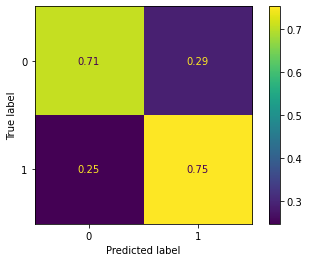

In [ ]:
preds = logr_G_m_under_clf.predict(X_test_G_m_under)

print(classification_report(Y_m_test, preds))

plot_confusion_matrix(logr_G_m_under_clf, X_test_G_m_under, Y_m_test, normalize='true');

In [ ]:
pd.DataFrame({'columns': X_cols_G_m_under, 'importance': logr_G_m_under_clf.coef_[0]})

,columns,importance
0,department,0.079138
1,education,0.062870
2,recruitment_channel,-0.074471
3,no_of_trainings,-0.303042
4,previous_year_rating,0.066337
5,KPIs_met>80%,2.429602
6,awards_won?,1.801845
7,avg_training_score,0.036325
8,starting_age,-0.063952
9,age_rating,0.075169


For each run, I check the classification report, then check the coefficients and delete the coefficient of least absolute value, then run again

First Run notes:
 - From classification_report (0,1) -- Precision: (.97,.19) -- Recall: (.71,.74) -- F-1: (.82,.30)
 - Delete 'region'

Second Run notes:
 - From classification_report (0,1) -- Precision: (.97,.19) -- Recall: (.71,.75) -- F-1: (.82,.30)
 - Delete 'age'

Third Run notes:
 - From classification_report (0,1) -- Precision: (.97,.19) -- Recall: (.71,.75) -- F-1: (.82,.30)
 - Delete 'length_of_service'

Fourth Run notes:
 - From classification_report (0,1) -- Precision: (.97,.19) -- Recall: (.71,.75) -- F-1: (.82,.30)
 - Add back in 'age'

Fifth Run notes:
 - From classification_report (0,1) -- Precision: (.97,.19) -- Recall: (.71,.75) -- F-1: (.82,.30)
 - Delete 'age' and 'total_training_score'

Sixth Run notes:
 - From classification_report (0,1) -- Precision: (.97,.19) -- Recall: (.71,.75) -- F-1: (.82,.30)
 - Delete 'previous_year_rating_norm'

Seventh Run notes:
 - From classification_report (0,1) -- Precision: (.97,.19) -- Recall: (.71,.76) -- F-1: (.82,.31)

The model with the best scores overall was X_cols=['department',	'education',	'recruitment_channel',	'no_of_trainings', 'previous_year_rating', 'KPIs_met>80%',	'awards_won?',	'avg_training_score',	'starting_age',	'age_rating',	'age_KPI']

## Female Plain Data

In [ ]:
X_cols_G_f = ['department',	'region', 'education',	'no_of_trainings',	'age',	'previous_year_rating', 
              'KPIs_met>80%',	'awards_won?',	'avg_training_score',	'starting_age',	'total_training_score', 
              'previous_year_rating_norm',	'age_rating',	'age_KPI']
Y_col = 'is_promoted'

X_train_G_f = female_X_train_df[X_cols_G_f]
Y_train_G_f = female_y_train_df[Y_col]

X_test_G_f = female_X_test_df[X_cols_G_f]
Y_f_test = female_y_test_df[Y_col]

In [ ]:
logr_G_f_clf.fit(X_train_G_f, Y_train_G_f)

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

              precision    recall  f1-score   support

           0       0.91      1.00      0.95      4454
           1       0.73      0.05      0.09       440

    accuracy                           0.91      4894
   macro avg       0.82      0.52      0.52      4894
weighted avg       0.90      0.91      0.88      4894



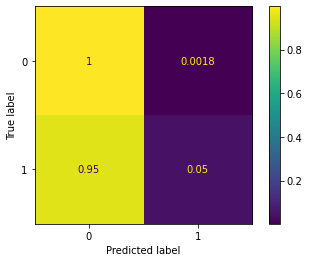

In [ ]:
preds = logr_G_f_clf.predict(X_test_G_f)

print(classification_report(Y_f_test, preds))

plot_confusion_matrix(logr_G_f_clf, X_test_G_f, Y_f_test, normalize='true');

In [ ]:
pd.DataFrame({'columns': X_cols_G_f, 'coefficients': logr_G_f_clf.coef_[0]})

,columns,coefficients
0,department,0.020730
1,region,-0.001928
2,education,0.244166
3,no_of_trainings,-1.601691
4,age,-0.069958
5,previous_year_rating,0.201837
6,KPIs_met>80%,2.205472
7,awards_won?,1.334310
8,avg_training_score,0.018004
9,starting_age,-0.003521


For each run, I check the classification report, then check the coefficients and delete the coefficient of least absolute value, then run again

First Run notes:
 - From classification_report (0,1) -- Precision: (.91,.74) -- Recall: (1.00,.05) -- F-1: (.95,.10)
 - Delete 'length_of_service'

Second Run notes:
 - From classification_report (0,1) -- Precision: (.91,.71) -- Recall: (1.00,.06) -- F-1: (.95,.11)
 - Delete 'region'

Third Run notes:
 - From classification_report (0,1) -- Precision: (.92,.67) -- Recall: (1.00,.06) -- F-1: (.95,.12)
 - Delete 'recruitment_channel'

Fourth Run notes:
 - From classification_report (0,1) -- Precision: (.91,.79) -- Recall: (1.00,.04) -- F-1: (.95,.08)
 - Add back in 'region'

Fifth Run notes:
 - From classification_report (0,1) -- Precision: (.91,.73) -- Recall: (1.00,.05) -- F-1: (.95,.09)

The model with the best scores overall X_cols without 'region' and 'length_of_service'

##Male Plain Data

In [ ]:
X_cols_G_m = ['department',	'education',	'recruitment_channel',	'no_of_trainings',	'age', 'previous_year_rating', 
              'length_of_service', 'KPIs_met>80%',	'awards_won?', 'avg_training_score',	'starting_age',	'total_training_score', 
              'age_rating',	'age_KPI']
Y_col = 'is_promoted'

X_train_G_m = male_X_train_df[X_cols_G_m]
Y_train_G_m = male_y_train_df[Y_col]

X_test_G_m = male_X_test_df[X_cols_G_m]
Y_m_test = male_y_test_df[Y_col]

In [ ]:
logr_G_m_clf.fit(X_train_G_m, Y_train_G_m)

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

              precision    recall  f1-score   support

           0       0.92      1.00      0.96     10589
           1       0.54      0.05      0.10       960

    accuracy                           0.92     11549
   macro avg       0.73      0.52      0.53     11549
weighted avg       0.89      0.92      0.89     11549



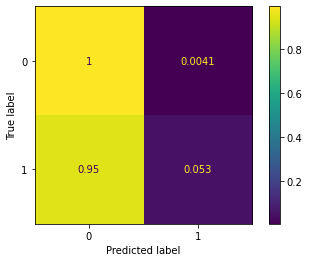

In [ ]:
preds = logr_G_m_clf.predict(X_test_G_m)

print(classification_report(Y_m_test, preds))

plot_confusion_matrix(logr_G_m_clf, X_test_G_m, Y_m_test, normalize='true');

In [ ]:
pd.DataFrame({'columns': X_cols_G_m, 'importance': logr_G_m_clf.coef_[0]})

,columns,importance
0,department,0.093926
1,education,0.052781
2,recruitment_channel,-0.021822
3,no_of_trainings,-1.931966
4,age,-0.028371
5,previous_year_rating,0.090587
6,length_of_service,0.012049
7,KPIs_met>80%,2.347280
8,awards_won?,1.674872
9,avg_training_score,0.008574


For each run, I check the classification report, then check the coefficients and delete the coefficient of least absolute value, then run again

First Run notes:
 - From classification_report (0,1) -- Precision: (.92,.53) -- Recall: (1.00,.05) -- F-1: (.96,.09)
 - Delete 'region'

Sec0nd Run notes:
 - From classification_report (0,1) -- Precision: (.92,.53) -- Recall: (1.00,.05) -- F-1: (.96,.09)
 - Delete 'avg_training_score'

Third Run notes:
 - From classification_report (0,1) -- Precision: (.92,.51) -- Recall: (.99,.06) -- F-1: (.96,.11)
 - Delete 'previous_year_rating_norm'

Fourth Run notes:
 - From classification_report (0,1) -- Precision: (.92,.55) -- Recall: (1.00,.05) -- F-1: (.96,.09)
 - Add back in 'avg_training_score'

Fifth Run notes:
 - From classification_report (0,1) -- Precision: (.92,.54) -- Recall: (1.00,.05) -- F-1: (.96,.10)

The model with the best scores overall X_cols without 'region' and 'avg_training_score'

## Results

The best F-1 score for Female Undersampling was: (.81,.31)

The best F-1 score for Male Undersampling was: (.82,.30)

The best F-1 score for Female Oversampling was: (.81,.31)

The best F-1 score for Male Oversampling was: (.82,.31)

The best F-1 score for Female Plain was: (.95,.12)

The best F-1 score for Male Plain was: (.96,.10)

The best results seem to come from Female and Male Oversampling

Female cols -- X_cols without region and length_of_service

Male cols -- X_cols without region and age

# Joblib

In [ ]:
import joblib

In [ ]:
joblib.dump(logr_G_f_over_clf, drive_dir + "logr_female_model.joblib")
joblib.dump(logr_G_m_over_clf, drive_dir + "logr_male_model.joblib")

['/content/drive/My Drive/Project_3/logr_male_model.joblib']

#Plots for most important columns

In [ ]:
feat_cols = ['department', 'region', 'education', 'gender', 'recruitment_channel', 'no_of_trainings', 'age', 
             'previous_year_rating', 'length_of_service', 'KPIs_met>80%', 'awards_won?', 'avg_training_score', 
             'starting_age', 'total_training_score', 'previous_year_rating_norm', 'age_rating', 'age_KPI']
target_col = 'is_promoted'

female_X_train_over = female_train_over_df[feat_cols]
female_y_train_over = female_train_over_df[target_col]

In [ ]:
male_X_train_over = male_train_over_df[feat_cols]
male_y_train_over = male_train_over_df[target_col]

In [ ]:
from xgboost.sklearn import XGBClassifier

In [ ]:
xgb_clf_f = XGBClassifier(learning_rate=0.1, max_depth=50, n_estimators=100)
xgb_clf_m = XGBClassifier(learning_rate=0.1, max_depth=50, n_estimators=100)

##Female

In [ ]:
xgb_clf_f.fit(female_X_train_over, female_y_train_over)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.1, max_delta_step=0, max_depth=50,
              min_child_weight=1, missing=None, n_estimators=100, n_jobs=1,
              nthread=None, objective='binary:logistic', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1)

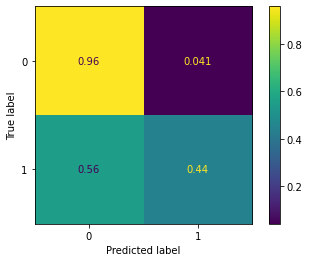

In [ ]:
plot_confusion_matrix(xgb_clf_f, female_X_test, female_y_test, normalize='true')

In [ ]:
female_pred = xgb_clf_f.predict(female_X_test)
print("Accuracy for female oversampled model: %.2f" % (accuracy_score(female_y_test, female_pred) * 100))

NameError: ignored

In [ ]:
female_pred_df = pd.DataFrame(female_pred, columns=['predictions'])

In [ ]:
female_pred_df.head()

In [ ]:
female_pred_df.to_csv(drive_dir + 'data/female_pred_xgb.csv')

In [ ]:
print(classification_report(female_y_test, female_pred))

In [ ]:
featured_f_df = pd.DataFrame(xgb_clf_f.feature_importances_, female_X_train_over.columns)

In [ ]:
featured_f_df = featured_f_df.sort_values(by=0, ascending=False)
featured_f_df[0] = featured_f_df[0]*100
featured_f_df = featured_f_df[:10]

In [ ]:
plt.figure(figsize=(20, 8))

x = featured_f_df.index
y = featured_f_df[0]

plt.title('Important Columns', fontsize =20)
plt.bar(x, y)
plt.xticks(rotation=45, fontsize = 12)
plt.ylabel('Percent', fontsize=14);

##Male

In [ ]:
xgb_clf_m.fit(male_X_train_over, male_y_train_over)

In [ ]:
plot_confusion_matrix(xgb_clf_m, male_X_test, male_y_test, normalize='true')

In [ ]:
male_pred = xgb_clf_m.predict(male_X_test)
print("Accuracy for male oversampled model: %.2f" % (accuracy_score(male_y_test, male_pred) * 100))

In [ ]:
male_pred_df = pd.DataFrame(male_pred, columns=['predictions'])

In [ ]:
male_pred_df.head()

In [ ]:
male_pred_df.to_csv(drive_dir + 'data/male_pred_xgb.csv')

In [ ]:
print(classification_report(male_y_test, male_pred))

In [ ]:
featured_m_df = pd.DataFrame(xgb_clf_m.feature_importances_, male_X_train_over.columns)

In [ ]:
featured_m_df = featured_m_df.sort_values(by=0, ascending=False)
featured_m_df[0] = featured_m_df[0]*100
featured_m_df = featured_m_df[:10]

In [ ]:
plt.figure(figsize=(20, 8))

x = featured_m_df.index
y = featured_m_df[0]

plt.title('Important Columns', fontsize =20)
plt.bar(x, y)
plt.xticks(rotation=45, fontsize = 12)
plt.ylabel('Percent', fontsize=14);

## IMPORTANT FOR GRAPHS

In [ ]:
female_train_over_df['previous_year_rating'] = female_train_over_df['previous_year_rating'].round(decimals=2)
male_train_over_df['previous_year_rating'] = male_train_over_df['previous_year_rating'].round(decimals=2)

In [ ]:
female_train_over_df['previous_year_rating'] = female_train_over_df['previous_year_rating'].replace(to_replace=3.33, value=0)
male_train_over_df['previous_year_rating'] = male_train_over_df['previous_year_rating'].replace(to_replace=3.33, value=0)

In [ ]:
df['department'].unique()

array(['Sales & Marketing', 'Operations', 'Technology', 'Analytics',
       'R&D', 'Procurement', 'Finance', 'HR', 'Legal'], dtype=object)

In [ ]:
le.fit(df['department'])

LabelEncoder()

In [ ]:
le_dept_list = le.inverse_transform([0,1,2,3,4,5,6,7,8])

In [ ]:
le_dept_list = ['Analytics', 'Finance', 'HR', 'Legal', 'Operations', 'Procurement',
       'R&D', 'Sales & Marketing', 'Technology']

In [ ]:
le_dept_list

['Analytics',
 'Finance',
 'HR',
 'Legal',
 'Operations',
 'Procurement',
 'R&D',
 'Sales & Marketing',
 'Technology']

In [ ]:
male_train_over_df['department'] = male_train_over_df['department'].replace([0,1,2,3,4,5,6,7,8], le_dept_list)
female_train_over_df['department'] = female_train_over_df['department'].replace([0,1,2,3,4,5,6,7,8], le_dept_list)

In [ ]:
male_train_over_df['department'].unique().tolist()

['HR',
 'Sales & Marketing',
 'Operations',
 'Analytics',
 'Procurement',
 'Technology',
 'R&D',
 'Finance',
 'Legal']

In [ ]:
male_train_over_df['department'].value_counts()

7    17068
4     8739
0     6623
8     6362
5     4716
1     2362
2     1519
6     1103
3      920
Name: department, dtype: int64

Label Encoded:

7  Sales & Marketing, 4  Operations, 0  Analytics, 8  Tech, 5  Procurement, 1 Finance, 2  HR, 6  R&D, 3  Legal


##Male Graphs

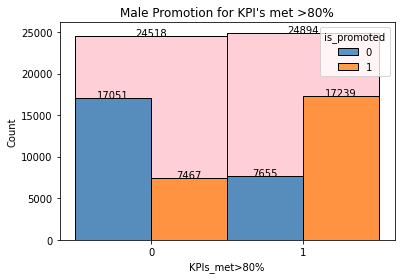

In [ ]:
m_kpi = sns.histplot(data= male_train_over_df, x= 'KPIs_met>80%', color='pink', bins=2, discrete=True)
sns.histplot(data= male_train_over_df, x= 'KPIs_met>80%', hue= 'is_promoted', bins= 2, discrete=True, multiple='dodge')
for p in m_kpi.patches:
 height = p.get_height()
 m_kpi.text(x = p.get_x()+(p.get_width()/2),
 y = height,
 s = '{:.0f}'.format(height),
 ha = 'center')
plt.title("Male Promotion for KPI's met >80%")
plt.xticks(male_train_over_df['KPIs_met>80%'].unique())
plt.savefig(drive_dir + 'images/male_features_kpi.png', format = 'png')

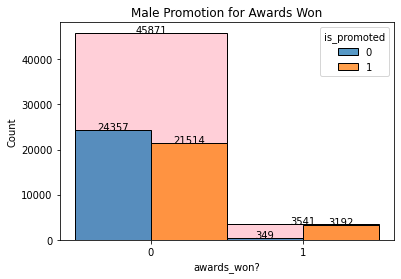

In [ ]:
m_awards = sns.histplot(data= male_train_over_df, x= 'awards_won?', color='pink', bins=2, discrete=True)
sns.histplot(data= male_train_over_df, x= 'awards_won?', hue= 'is_promoted', bins=2, discrete=True, multiple='dodge')
for p in m_awards.patches:
 height = p.get_height()
 m_awards.text(x = p.get_x()+(p.get_width()/2),
 y = height,
 s = '{:.0f}'.format(height),
 ha = 'center')
plt.title("Male Promotion for Awards Won")
plt.xticks(male_train_over_df['awards_won?'].unique())
plt.savefig(drive_dir + 'images/male_features_awards.png', format = 'png')

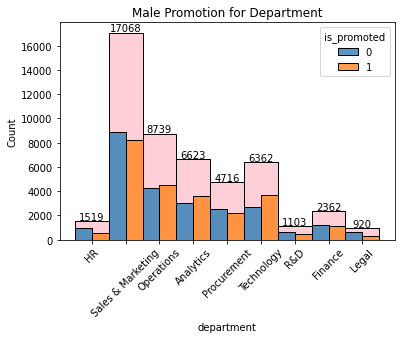

In [ ]:
m_dept_tot = sns.histplot(data= male_train_over_df, x= 'department', color='pink', discrete=True)
for p in m_dept_tot.patches:
 height = p.get_height()
 m_dept_tot.text(x = p.get_x()+(p.get_width()/2),
 y = height+100,
 s = '{:.0f}'.format(height),
 ha = 'center')
m_dept = sns.histplot(data= male_train_over_df, x= 'department', hue= 'is_promoted', multiple='dodge', discrete=True)
plt.title("Male Promotion for Department")
m_dept_tot.set_xticklabels(rotation=45, labels=male_train_over_df['department'].unique().tolist())
plt.savefig(drive_dir + 'images/male_features_dept.png', format = 'png')

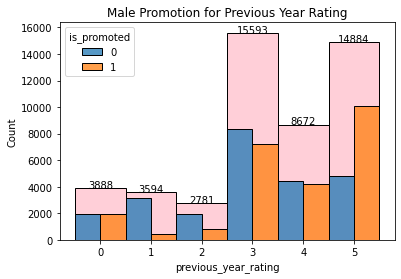

In [ ]:
m_rating_tot = sns.histplot(data= male_train_over_df, x= 'previous_year_rating', color='pink', bins=20, discrete=True)
for p in m_rating_tot.patches:
 height = p.get_height()
 m_rating_tot.text(x = p.get_x()+(p.get_width()/2),
 y = height,
 s = '{:.0f}'.format(height),
 ha = 'center')
m_rating = sns.histplot(data= male_train_over_df, x= 'previous_year_rating', hue= 'is_promoted', bins=20, discrete=True, multiple='dodge')
plt.title("Male Promotion for Previous Year Rating")
plt.savefig(drive_dir + 'images/male_features_rating.png', format = 'png')

## Female Graphs

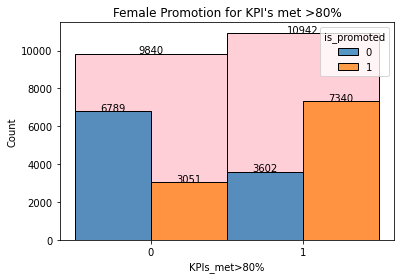

In [ ]:
f_kpi = sns.histplot(data= female_train_over_df, x= 'KPIs_met>80%', color='pink', bins=2, discrete=True)
sns.histplot(data= female_train_over_df, x= 'KPIs_met>80%', hue= 'is_promoted', bins=2, discrete=True, multiple='dodge')
for p in f_kpi.patches:
 height = p.get_height()
 f_kpi.text(x = p.get_x()+(p.get_width()/2),
 y = height,
 s = '{:.0f}'.format(height),
 ha = 'center')
plt.title("Female Promotion for KPI's met >80%")
plt.xticks(female_train_over_df['KPIs_met>80%'].unique())
plt.savefig(drive_dir + 'images/female_features_kpi.png', format = 'png')

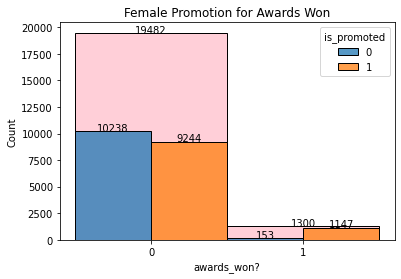

In [ ]:
f_awards = sns.histplot(data= female_train_over_df, x= 'awards_won?', color='pink', bins=2, discrete=True)
sns.histplot(data= female_train_over_df, x= 'awards_won?', hue= 'is_promoted', bins=2, discrete=True, multiple='dodge')
for p in f_awards.patches:
 height = p.get_height()
 f_awards.text(x = p.get_x()+(p.get_width()/2),
 y = height,
 s = '{:.0f}'.format(height),
 ha = 'center')
plt.title("Female Promotion for Awards Won")
plt.xticks(female_train_over_df['awards_won?'].unique())
plt.savefig(drive_dir + 'images/female_features_awards.png', format = 'png')

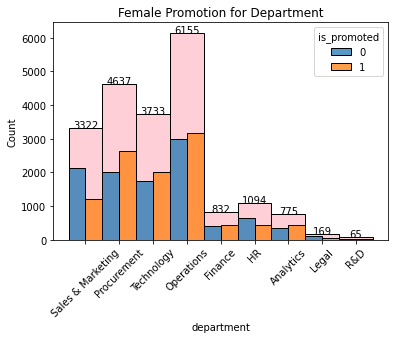

In [ ]:
f_dept_tot = sns.histplot(data= female_train_over_df, x= 'department', color='pink', bins=9, discrete=True)
for p in f_dept_tot.patches:
 height = p.get_height()
 f_dept_tot.text(x = p.get_x()+(p.get_width()/2),
 y = height,
 s = '{:.0f}'.format(height),
 ha = 'center')
f_dept = sns.histplot(data= female_train_over_df, x= 'department', hue= 'is_promoted', multiple='dodge', bins=9, discrete=True)
plt.title("Female Promotion for Department")
f_dept_tot.set_xticklabels(rotation=45, labels=female_train_over_df['department'].unique().tolist())
plt.savefig(drive_dir + 'images/female_features_dept.png', format = 'png')

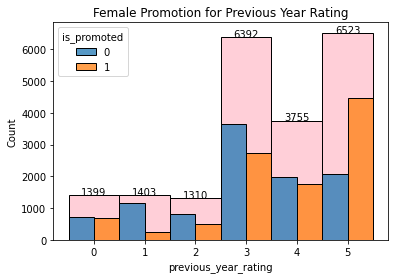

In [ ]:
f_rating_tot = sns.histplot(data= female_train_over_df, x= 'previous_year_rating', color='pink', bins=6, discrete=True)
for p in f_rating_tot.patches:
 height = p.get_height()
 f_rating_tot.text(x = p.get_x()+(p.get_width()/2),
 y = height,
 s = '{:.0f}'.format(height),
 ha = 'center')
f_rating = sns.histplot(data= female_train_over_df, x= 'previous_year_rating', hue= 'is_promoted', bins=6, discrete=True, multiple='dodge')
plt.title("Female Promotion for Previous Year Rating")
plt.xticks(female_train_over_df['previous_year_rating'].unique())
plt.savefig(drive_dir + 'images/female_features_rating.png', format = 'png')

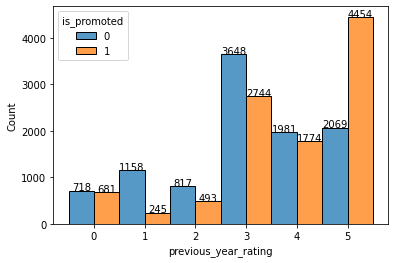

In [ ]:
f_rating = sns.histplot(data= female_train_over_df, x= 'previous_year_rating', hue= 'is_promoted', bins=6, discrete=True, multiple='dodge')
for p in f_rating.patches:
 height = p.get_height()
 f_rating.text(x = p.get_x()+(p.get_width()/2),
 y = height,
 s = '{:.0f}'.format(height),
 ha = 'center')